In [1]:
!pip install pmdarima

In [2]:
!pip install missingno

In [3]:
!pip install kaleido

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
sns.set(style='white')
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
df = pd.read_csv('KOTAKBANK.csv')

In [7]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,KOTAKMAH,EQ,212.35,220.0,229.35,220.00,229.35,229.35,229.13,7086,1.623640e+11,NaN,NaN,NaN
1,2000-01-04,KOTAKMAH,EQ,229.35,247.7,247.70,225.25,247.70,246.95,244.12,73681,1.798729e+12,NaN,NaN,NaN
2,2000-01-05,KOTAKMAH,EQ,246.95,229.0,240.00,227.20,228.00,228.40,233.75,105799,2.473093e+12,NaN,NaN,NaN
3,2000-01-06,KOTAKMAH,EQ,228.40,235.1,239.00,217.00,224.95,225.90,226.84,40202,9.119546e+11,NaN,NaN,NaN
4,2000-01-07,KOTAKMAH,EQ,225.90,213.0,219.00,207.85,207.85,208.85,209.94,24463,5.135747e+11,NaN,NaN,NaN


In [8]:
# Exploratory Data Analysis
def eda(data):
    print("Size and shape of the data: ")
    print(data.size)
    print(data.shape)
    print('-'*50)
    print("\nData types of the features: ")
    print(data.dtypes)
    
eda(df)

Size and shape of the data: 
74775
(4985, 15)
--------------------------------------------------

Data types of the features: 
Date                   object
Symbol                 object
Series                 object
Prev Close            float64
Open                  float64
High                  float64
Low                   float64
Last                  float64
Close                 float64
VWAP                  float64
Volume                  int64
Turnover              float64
Trades                float64
Deliverable Volume    float64
%Deliverble           float64
dtype: object


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'], inplace=True)

In [10]:
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,KOTAKMAH,EQ,212.35,220.0,229.35,220.00,229.35,229.35,229.13,7086,1.623640e+11,NaN,NaN,NaN
2000-01-04,KOTAKMAH,EQ,229.35,247.7,247.70,225.25,247.70,246.95,244.12,73681,1.798729e+12,NaN,NaN,NaN
2000-01-05,KOTAKMAH,EQ,246.95,229.0,240.00,227.20,228.00,228.40,233.75,105799,2.473093e+12,NaN,NaN,NaN
2000-01-06,KOTAKMAH,EQ,228.40,235.1,239.00,217.00,224.95,225.90,226.84,40202,9.119546e+11,NaN,NaN,NaN
2000-01-07,KOTAKMAH,EQ,225.90,213.0,219.00,207.85,207.85,208.85,209.94,24463,5.135747e+11,NaN,NaN,NaN


In [11]:
df.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,4985.000000,4985.000000,4985.000000,4985.000000,4985.000000,4985.000000,4985.000000,4.985000e+03,4.985000e+03,2456.000000,4.789000e+03,4789.000000
mean,696.291755,697.154925,708.147543,684.984112,696.556409,696.615135,696.772050,1.283626e+06,1.355506e+14,54912.741857,6.701163e+05,0.514785
std,440.761023,441.037354,445.558375,435.579256,440.924524,440.938692,440.580761,2.486726e+06,3.589591e+14,60401.337897,1.577341e+06,0.166689
min,27.300000,26.950000,30.000000,26.000000,26.500000,27.300000,27.670000,1.050000e+02,4.608250e+08,375.000000,1.002000e+03,0.062300
25%,355.150000,355.000000,366.900000,346.650000,356.000000,355.600000,355.180000,1.855800e+05,5.388055e+12,19646.500000,1.126580e+05,0.401600
50%,650.950000,652.650000,662.000000,638.450000,650.500000,651.200000,651.390000,7.506900e+05,5.000255e+13,33764.500000,3.548760e+05,0.511100
75%,966.400000,967.000000,979.600000,955.250000,968.000000,966.850000,966.270000,1.577817e+06,1.243851e+14,66802.500000,8.194760e+05,0.631900
max,2019.650000,2016.700000,2049.000000,1999.000000,2023.900000,2019.650000,2028.690000,8.385990e+07,1.498222e+16,846705.000000,5.853186e+07,0.990100


In [12]:
def missing_value_table(df):
    mis_val = df.isnull().sum()
    
    mis_val_percent = 100*mis_val/len(df)
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns={0:'Missing Values', 1:'% of Total Values'})
    #sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] !=0].sort_values(
    '% of Total Values', ascending=False).round(1)
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    return mis_val_table_ren_columns
    

In [13]:
missing_table = missing_value_table(df)
missing_table

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Trades,2529,50.7
Deliverable Volume,196,3.9
%Deliverble,196,3.9


<Axes: >

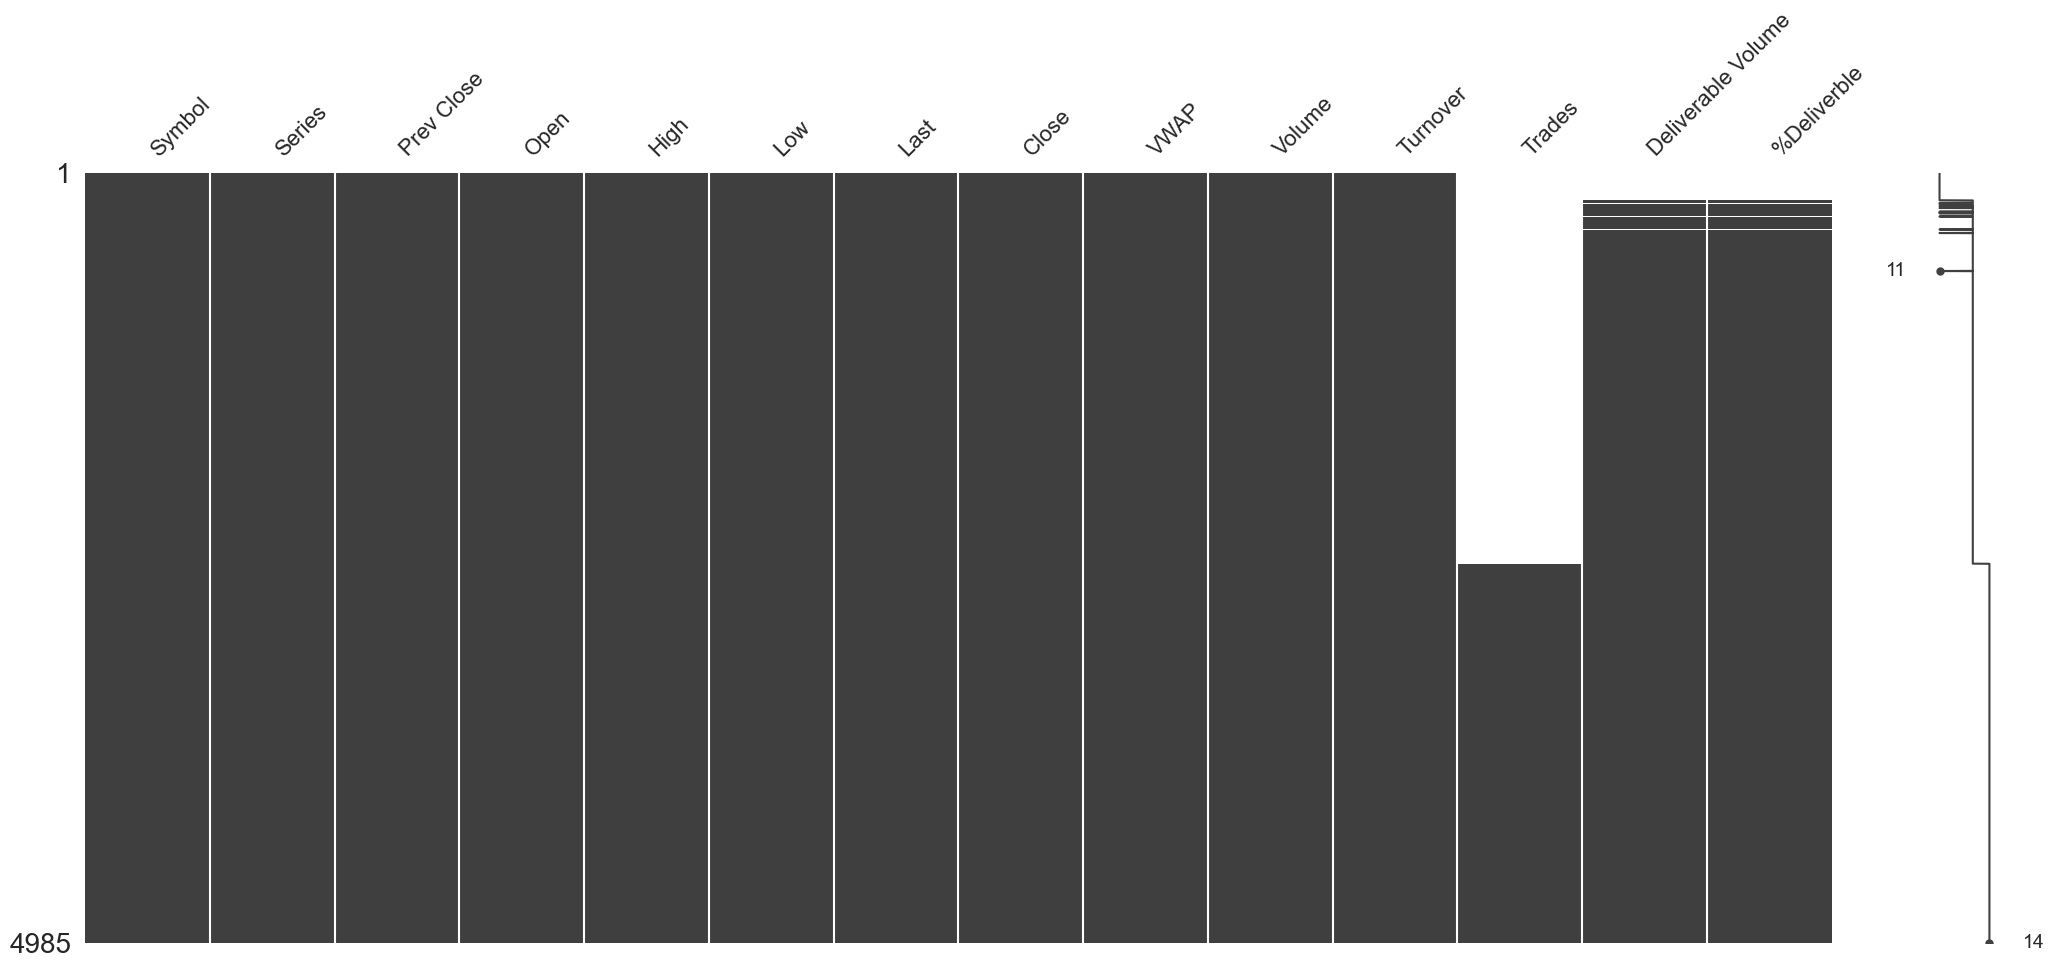

In [14]:
msno.matrix(df)

<Axes: xlabel='Date'>

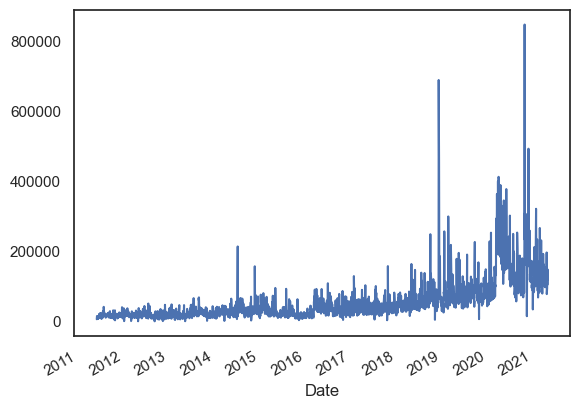

In [15]:
df.Trades.plot()

In [16]:
df.Trades[:2000]

Date
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
2000-01-06   NaN
2000-01-07   NaN
              ..
2009-04-09   NaN
2009-04-13   NaN
2009-04-15   NaN
2009-04-16   NaN
2009-04-17   NaN
Name: Trades, Length: 2000, dtype: float64

In [17]:
# Removing missing values

df.drop(['Trades', 'Deliverable Volume','%Deliverble'],axis=1,inplace=True)

In [18]:

import plotly.io as pio
pio.renderers.default = "notebook_connected"


fig = go.Figure([go.Scatter(x=df.index, y=df['VWAP'])])
fig.update_layout(
    autosize = False,
    width = 1000,
    height = 500,
    title ='VMAP over time',
    template='simple_white'
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="VWAP")
fig.show()

/var/folders/ss/v59ygfzj7m1dkgsklj3ck7m80000gn/T/ipykernel_66678/947576900.py:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




<Axes: xlabel='VWAP', ylabel='Density'>

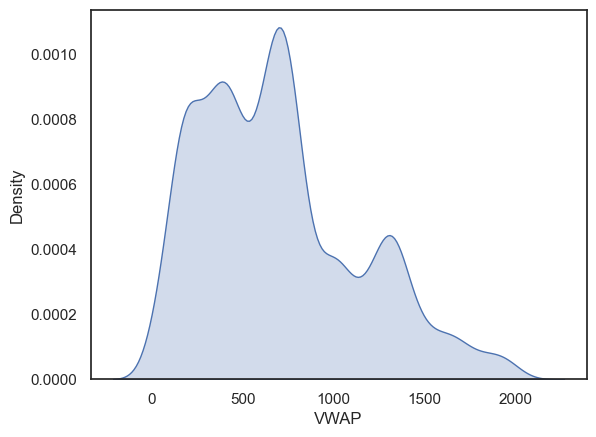

In [19]:
sns.kdeplot(df['VWAP'], shade=True)

In [20]:

fig = go.Figure([go.Scatter(x=df.loc['2019', 'VWAP'].index, y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize = False,
    width = 1000,
    height=500,
    title='VWAP in 2019',
    template="simple_white"
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title='VWAP')
fig.show()

In [21]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'VWAP'].index, y=df.loc['2020', 'VWAP'])])
fig.update_layout(
    autosize = False,
    width = 1000,
    height=500,
    title='VWAP in 2020',
    template="simple_white"
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title='VWAP')
fig.show()

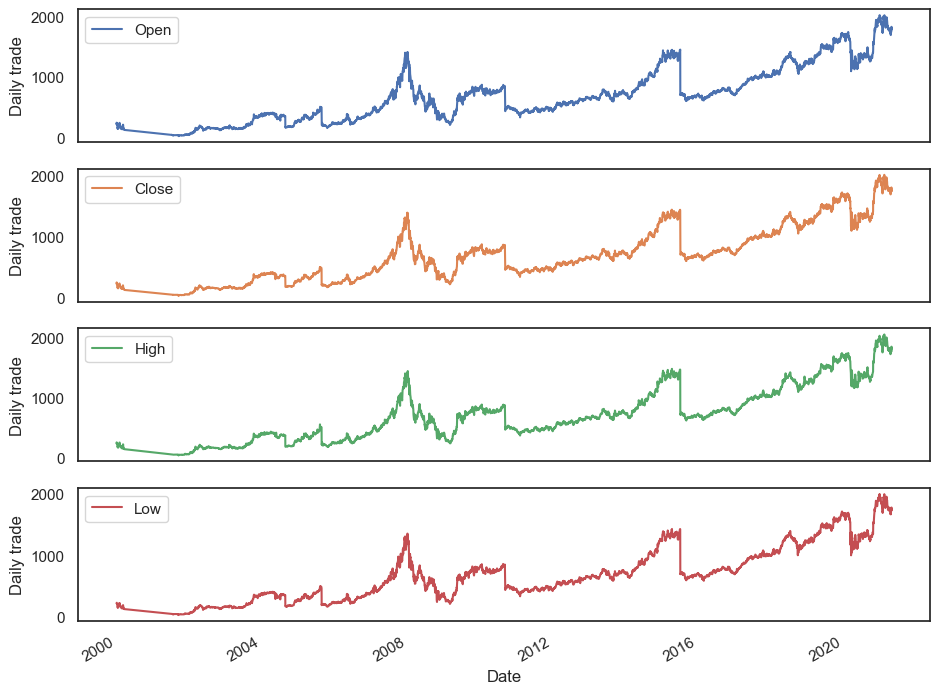

In [22]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = df[cols_plot].plot(figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

In [23]:
##VOLUME
fig = go.Figure([go.Scatter(x=df.index, y=df['Volume'])])
fig.update_layout(
    autosize=False,
    width = 1000,
    height = 500,
    template = 'simple_white',
    title='Volume over time'
)
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Volume')
fig.show()

In [24]:
fig = go.Figure([go.Scatter(x=df.loc['2020', 'Volume'].index, y=df.loc['2020', 'Volume'])])
fig.update_layout(
    autosize=False,
    width = 1000,
    height = 500,
    template = 'simple_white',
    title = 'Volume in 2020'
)
fig.update_xaxes(title='Date'),
fig.update_yaxes(title='Volume')
fig.show()

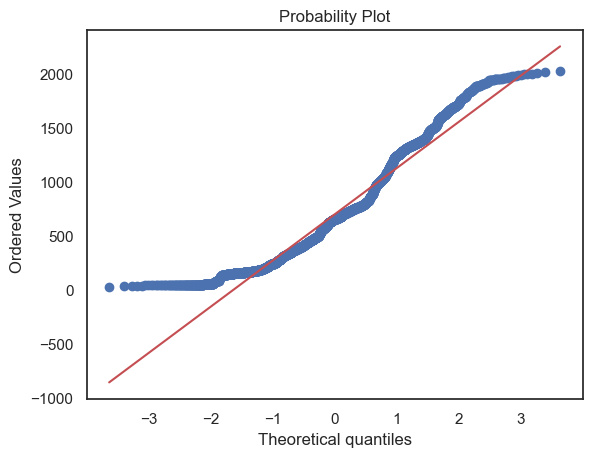

In [25]:
scipy.stats.probplot(df.VWAP, plot=pylab)
pylab.show()

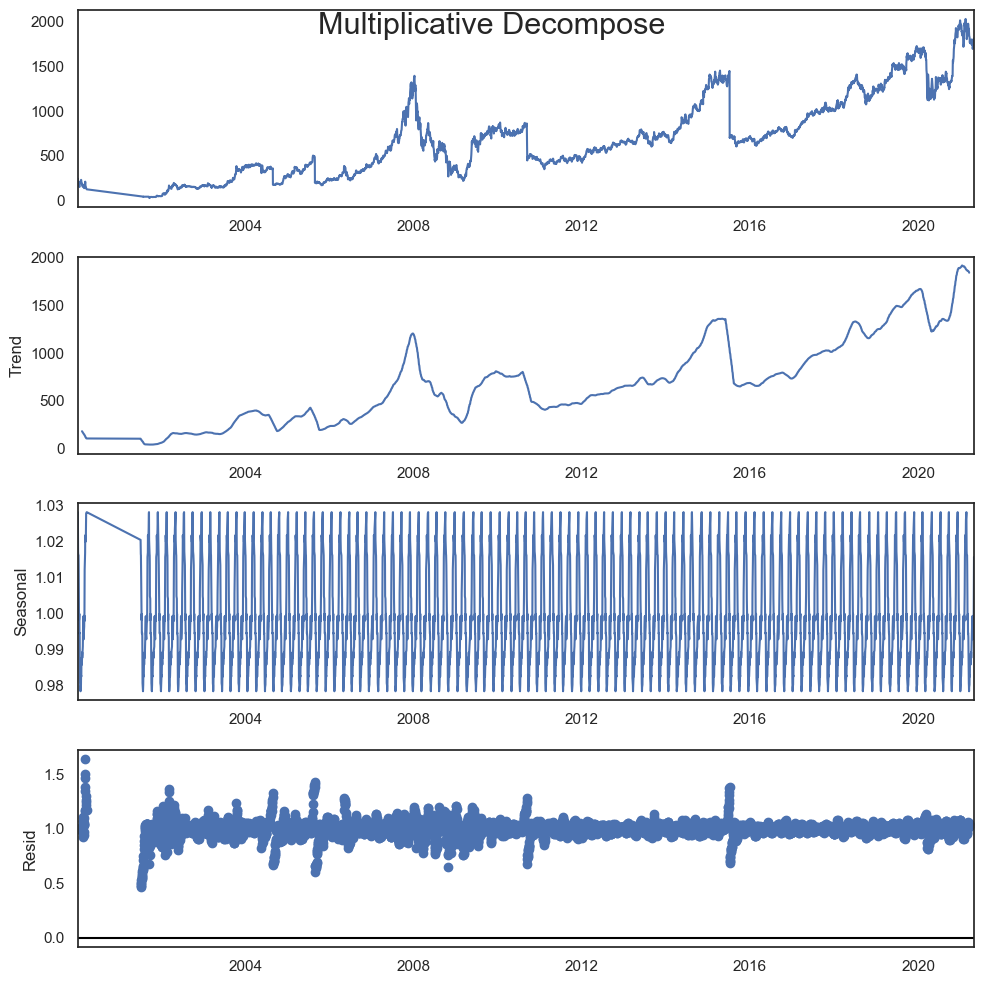

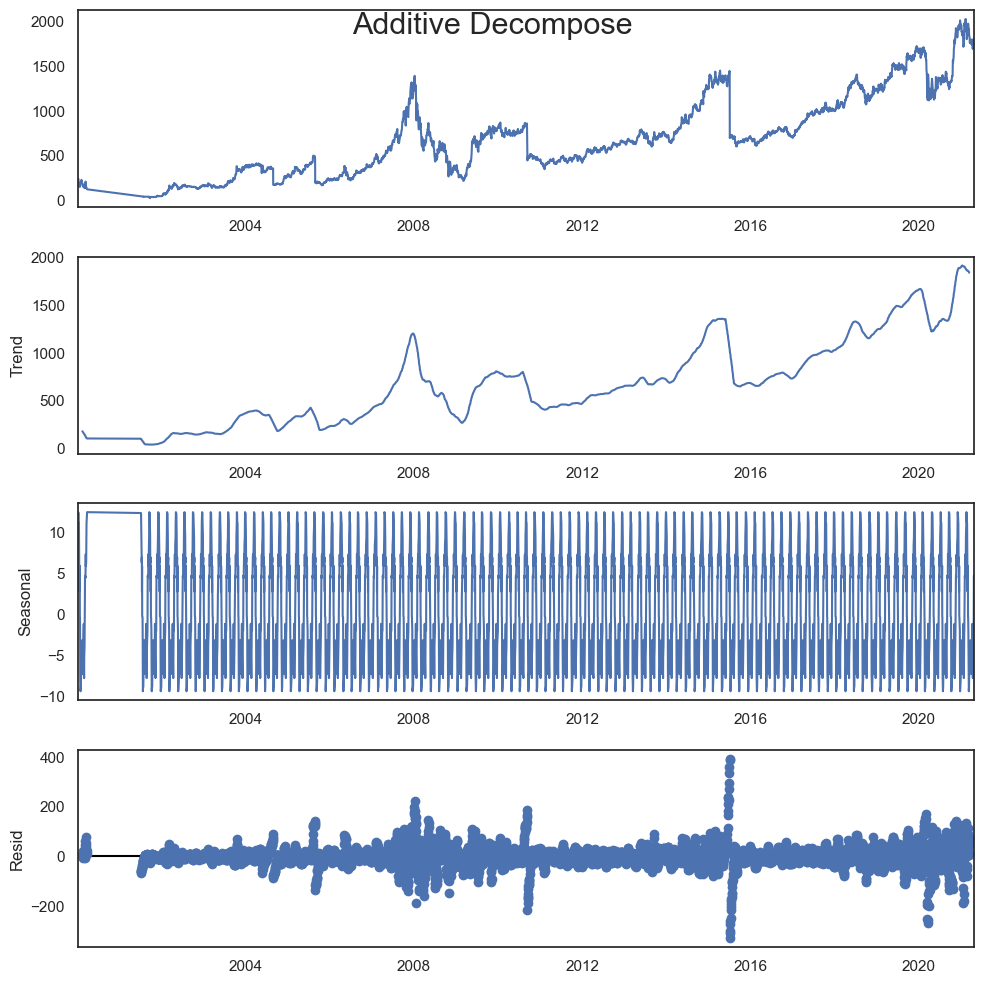

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

plt.rcParams.update({"figure.figsize":(10,10)})
y = df['VWAP'].to_frame()

# Multiplicative Decomoposition
result_mul = seasonal_decompose(y, model='multiplicative',period=52)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 52)
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()